## 通过AB测试分析是否应该使用新页面


## 目录
- [简介](#intro)
- [I - 转化率](#probability)
- [II - 假设检验](#ab_test)
- [III - 逻辑回归](#regression)
- [Ⅳ - 结论](#regression)

<a id='intro'></a>
### 简介

在这个项目中，某公司为了提高用户转化率，设计了新的网站页面，并设计了一个A/B 测试。测试数据存储在csv文件中，文件包含user_id、发生时间、用户分组及是否转化等列（转化用1表示，未转化用0表示）。本项目通过假设检验和逻辑回归分析新、旧页面转化率是否具有显著性差异，从而判断是否应该采用新页面。

<a id='probability'></a>
#### I - 转化率


In [10]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

#设置随机发生器种子为42，以确保每次运行结果一致
random.seed(42)

C:\Users\Liu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**`1.` 熟悉数据集。**

In [11]:
df=pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
df.info()
#数据集无空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**2. 数据清洗**

In [13]:
df.duplicated().sum()
#数据集无重复行

0

"group"的control、treatment和"landing_page"的old_page、new_page应该一一对应，但经查询发现并非如此

In [14]:
df_t=df.query('group=="treatment"').shape[0]
df_n=df.query('landing_page=="new_page"').shape[0]
df_t_n=df.query('group=="treatment" & landing_page=="new_page"').shape[0]
df_t,df_n,df_t_n

df_t-df_t_n+df_n-df_t_n

3893

去掉"group"和"landing_page"不一致的行，并将新数据帧命名为df2

In [15]:
df1=df.drop(df[(df['group']=="treatment") & (df['landing_page']=="old_page")].index,axis=0)
df2=df1.drop(df[(df['group']=="control") & (df['landing_page']=="new_page")].index,axis=0)
df2.shape

(290585, 5)

判断df2中"user_id"列是否有重复id，若有则去掉

In [16]:
df2['user_id'].nunique()

290584

In [17]:
df2['user_id'].mode()

0    773192
dtype: int64

In [18]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
df2.drop([1899],axis=0,inplace=True)

计算整个数据集用户的转化率

In [20]:
df2.query('converted==1').shape[0]/df2.shape[0]

0.11959708724499628

计算 control 组中的转化率

In [21]:
df2_con=df2.query('group=="control"')
p_con=df2_con.query('converted==1').shape[0]/df2_con.shape[0]
p_con

0.1203863045004612

计算treatment组中的转化率

In [22]:
df2_tre=df2.query('group=="treatment"')
p_tre=df2_tre.query('converted==1').shape[0]/df2_tre.shape[0]
p_tre

0.11880806551510564

**小结：总体、实验组、对照组三者的准化率差异太小，在没有其它证据时，不能证明新页面比旧页面带来更多的转化。**

**接下来我们使用假设检验更严格地分析新旧页面的转化率是否具有统计学显著差异性**

<a id='ab_test'></a>
### II - 假设检验

**1.令 **$p_{old}$** 与 **$p_{new}$** 分别为旧页面与新页面的转化率，则假设检验的零假设和备择假设分别如下:**

$H_{0}$: $p_{old}$>=$p_{new}$

$H_{1}$: $p_{old}$<$p_{new}$

**2.在假设检验中，我们先假定零假设为真，并在此基础上计算P值，将其与显著性水平0.05比较。若P<=0.05，则拒绝零假设；反之，则拒绝备择假设。**

In [23]:
p_new=df2.query('converted==1').shape[0]/df2.shape[0]
p_old=df2.query('converted==1').shape[0]/df2.shape[0]
n_new=df2.query('landing_page=="new_page"').shape[0]
n_old=df2.query('landing_page=="old_page"').shape[0]

使用random.choice()函数分布模拟control、treatment组的用户转化行为，并多次重复此模拟行为

In [24]:
random.seed(42)
p_diffs=[]
for i in range(10000):
    new_page_converted=np.random.choice([0,1],n_new,p=[1-p_new,p_new])
    old_page_converted=np.random.choice([0,1],n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

绘制直方图

(array([   21.,   125.,   559.,  1548.,  2616.,  2563.,  1679.,   685.,
          173.,    31.]),
 array([ -4.28308474e-03,  -3.43445680e-03,  -2.58582887e-03,
         -1.73720094e-03,  -8.88573002e-04,  -3.99450682e-05,
          8.08682865e-04,   1.65731080e-03,   2.50593873e-03,
          3.35456667e-03,   4.20319460e-03]),
 <a list of 10 Patch objects>)

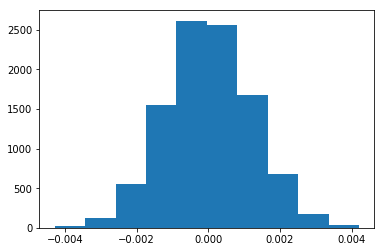

In [25]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)

**3.根据实际数据集中的control、treatment组的转化率差异（即p_tre、p_con之差）计算P值。**

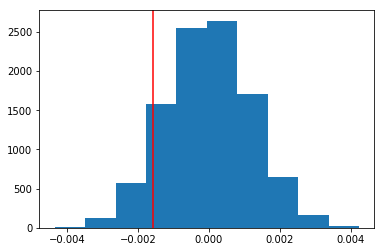

In [26]:
null_vals=np.random.normal(0,np.std(p_diffs),10000)
obs_diff=p_tre-p_con
plt.hist(null_vals)
plt.axvline(obs_diff,color="r")

In [27]:
P=(null_vals>obs_diff).mean()
P

0.90549999999999997

**小结：P>0.05，我们没有足够证据拒绝零假设。即：新旧页面的转化率不存在显著性差异，不推荐使用新页面。**

<a id='regression'></a>
### III - 逻辑回归

**1.由于因变量（converted）是离散变量，为了研究group与converted的关系，我们可以通过逻辑回归来计算P值，以此验证假设检验得出的结论是否正确。**

在数据集上以"group"列为基础添加虚拟变量列，并命名为"ab_page"，令treatment组为1，control为0。另外添加一列为截距。

In [28]:
df2_dummies=pd.get_dummies(df2['group'])
df2['ab_page']=df2_dummies['treatment']
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


使用创建的2列来拟合逻辑回归模型，并输出结果摘要

In [29]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])

In [30]:
res=lm.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:14:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**逻辑回归计算的P值为0.19，大于0.05，无足够证据拒绝零假设，即：新旧页面的转化率不存在显著性差异，不推荐使用新页面。此结论与假设检验结论吻合。注意：假设检验与逻辑回归P值不同是因为前者执行的是单尾检验，零假设和备择假设分别为：$H_{0}$: $p_{old}$>=$p_{new}$，$H_{1}$: $p_{old}$<$p_{new}$；后者执行的是双尾检验，零假设和备择假设分别为：$H_{0}$: $p_{old}$=$p_{new}$，$H_{1}$: $p_{old}$≠$p_{new}$。**

# 结论
** 根据上述分析结果，新旧页面的转化率不存在显著性差异，不推荐使用新页面。**